In [10]:
import pandas as pd
import random
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import model_selection
from importlib import reload
from tqdm import tqdm
from tqdm import tqdm_notebook
import shutil

In [13]:
def solve(img_path, mask_path, increment, root_dir, out_dir):
  img = cv2.imread(os.path.join(root_dir, img_path))
  mask = cv2.imread(os.path.join(root_dir, mask_path), cv2.IMREAD_GRAYSCALE)


  plt.imshow(mask)
  plt.show()

  pixels = (increment * increment) 
  _ratio = float(cv2.countNonZero(mask) / (mask.shape[0] * mask.shape[1])) * 100.0
  #print("Ratio printing: " + str(_ratio))
  Images = [] #Data
  Masks = []
  if _ratio >= 8.0:
    print("Call 1")
    d = mask.shape
    stride = int(increment / 2) #Change kore kore dekha laagbe.. suggested: increment / 2
    for i in range(0, d[0], stride):
      for j in range(0, d[1], stride):
        x = i + increment
        y = j + increment
        if x >= d[0] or y >= d[1]:
          break
        mask_patch = mask[i : x, j : y]
        bits = cv2.countNonZero(mask_patch)
        if bits == 0 or bits == pixels:
          continue
        ratio = float(bits / pixels) * 100.0
        if float(bits / pixels) * 100.0 > 65.0 or float(bits / pixels) * 100 < 5.0:
          print("Percentage: " + str(float(bits/pixels) * 100.0))
          plt.imshow(mask_patch)
          plt.show()
          continue
        valid = False
        for rows in range(mask_patch.shape[0]):
          for cols in range(mask_patch.shape[1]):
            if rows == 0 or cols == 0 or rows == mask_patch.shape[0] - 1 or cols == mask_patch.shape[1] - 1:
              if mask_patch[rows][cols] != 0:
                valid = True
        if valid == False:
          continue
        img_patch = img[i : x, j : y]
        Images.append(img_patch)
        Masks.append(mask_patch)
    
    #print("opt 1")
  else:
    # less than 8%
    print("Call 2")
    dims = mask.shape
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
      x, y, w, h = cv2.boundingRect(c)
      if h >= w:
        lower_y = int(y + h / 2)
        lower_x = x
        upper_y = max(0, int(lower_y - increment))
        upper_x = x
        for change in range(int(increment / 2) - 10):
          if lower_x - 1 > 0:
            lower_x -= 1
            upper_x -= 1
          else:
            break
        while True:
          if lower_x + increment >= dims[1]:
            lower_x = max(0, lower_x - 1)
          elif lower_y + increment >= dims[0]:
            lower_y = max(0, lower_y - 1)
          else:
            break
        while True:
          if upper_x + increment >= dims[1]:
            upper_x = max(upper_x - 1, 0)
          elif upper_y + increment >= dims[0]:
            upper_y = max(upper_y - 1, 0)
          else:
            break
        mask_patch1 = mask[upper_y : upper_y + increment, upper_x : upper_x + increment]
        mask_patch2 = mask[lower_y : lower_y + increment, lower_x : lower_x + increment]
        valid1 = False
        valid2 = False
        for rows in range(mask_patch1.shape[0]):
          for cols in range(mask_patch1.shape[1]):
            if rows == 0 or cols == 0 or rows == mask_patch1.shape[0] - 1 or cols == mask_patch1.shape[1] - 1:
              if mask_patch1[rows][cols] != 0:
                valid1 = True
              if mask_patch2[rows][cols] != 0:
                valid2 = True
        if valid1:
          ratio = float(cv2.countNonZero(mask_patch1) / (increment * increment)) * 100.0
          if ratio >= 65.0: 
            continue
          image_patch1 = img[upper_y : upper_y + increment, upper_x : upper_x + increment]
          Images.append(image_patch1)
          Masks.append(mask_patch1)
        if valid2:
          ratio = float(cv2.countNonZero(mask_patch2) / (increment * increment)) * 100.0
          if ratio >= 65.0:
            continue
          image_patch2 = img[lower_y : lower_y + increment, lower_x : lower_x + increment]
          Images.append(image_patch2)
          Masks.append(mask_patch2)
      else:
        lower_y = y
        lower_x = int(x + w / 2)
        upper_y = y
        upper_x = max(0, lower_x - increment)
        for change in range(int(increment / 2) - 10):
          if lower_y - 1 > 0:
            lower_y -= 1
            upper_y -= 1
          else:
            break
        while True:
          if lower_x + increment >= dims[1]:
            lower_x = max(0, lower_x - 1)
          elif lower_y + increment >= dims[0]:
            lower_y = max(0, lower_y - 1)
          else:
            break
        while True:
          if upper_x + increment >= dims[1]:
            upper_x = max(upper_x - 1, 0)
          elif upper_y + increment >= dims[0]:
            upper_y = max(upper_y - 1, 0)
          else:
            break
        mask_patch1 = mask[upper_y : upper_y + increment, upper_x : upper_x + increment]
        mask_patch2 = mask[lower_y : lower_y + increment, lower_x : lower_x + increment]
        valid1 = False
        valid2 = False
        for rows in range(mask_patch1.shape[0]):
          for cols in range(mask_patch1.shape[1]):
            if rows == 0 or cols == 0 or rows == mask_patch1.shape[0] - 1 or cols == mask_patch1.shape[1] - 1:
              if mask_patch1[rows][cols] != 0:
                valid1 = True
              if mask_patch2[rows][cols] != 0:
                valid2 = True
        if valid1:
          ratio = float(cv2.countNonZero(mask_patch1) / (increment * increment)) * 100.0
          if ratio >= 65.0:
            continue
          image_patch1 = img[upper_y : upper_y + increment, upper_x : upper_x + increment]
          Images.append(image_patch1)
          Masks.append(mask_patch1)
        if valid2:
          ratio = float(cv2.countNonZero(mask_patch2) / (increment * increment)) * 100.0
          if ratio >= 65.0:
            continue
          image_patch2 = img[lower_y : lower_y + increment, lower_x : lower_x + increment]
          Images.append(image_patch2)
          Masks.append(mask_patch2)
    
    #print("opt 2")
  
  print("Number of patches and masks: " + str(len(Images))  + " " + str(len(Masks)))
  for im, ms in zip(Images, Masks):
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(im)

    plt.subplot(122)
    plt.imshow(ms)
    plt.show()
    

In [6]:
dataframe = pd.read_csv('casia2.csv')

<IPython.core.display.Javascript object>

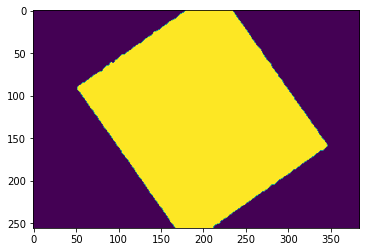

Call 1
Percentage: 70.21484375


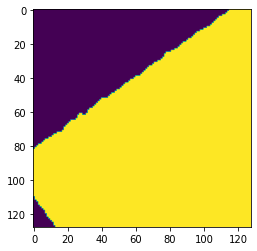

Percentage: 92.108154296875


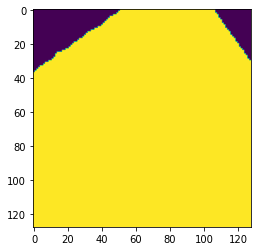

Percentage: 68.072509765625


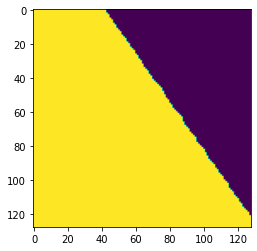

Percentage: 83.917236328125


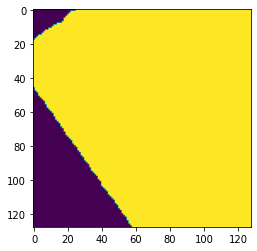

Percentage: 91.961669921875


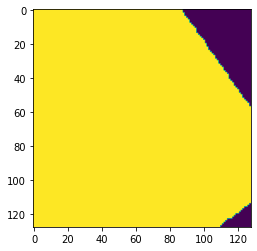

Number of patches and masks: 2 2


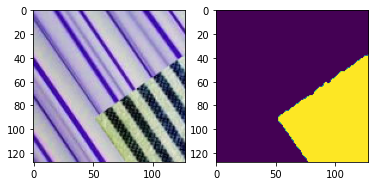

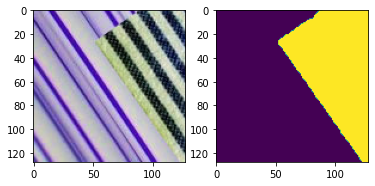

In [14]:
ROOT_DIR = 'Image_Manipulation_Dataset/CASIA_2.0'

# for i in range(len(dataframe)):
solve('Tp/Tp_D_CRN_M_N_txt00017_txt00063_10836.jpg', 'Gt/Tp_D_CRN_M_N_txt00017_txt00063_10836_gt.png', 128, root_dir=ROOT_DIR, out_dir="") # 64 x 64 size img
    # if i == 10:
    #     break


In [6]:
dirs = os.listdir('Image_Manipulation_Dataset/CASIA_2.0/image_patch_64')
incomplete = []
for dir in dirs:
    if os.path.exists(os.path.join('Image_Manipulation_Dataset/CASIA_2.0/image_patch_64', dir, 'done.txt')):
        continue
    else:
        incomplete.append(dir)

In [5]:
import shutil
for _ in incomplete:
    shutil.rmtree(os.path.join('Image_Manipulation_Dataset/CASIA_2.0/image_patch_64',_))

In [23]:
df = pd.read_csv('cmfd_FULL.csv')
df.head()

,image_patch,mask_patch,label,fold,ela
0,real/000000000139.jpg,NaN,0,-1,real/000000000139_ela.jpg
1,real/000000000632.jpg,NaN,0,-1,real/000000000632_ela.jpg
2,real/000000000785.jpg,NaN,0,-1,real/000000000785_ela.jpg
3,real/000000000802.jpg,NaN,0,-1,real/000000000802_ela.jpg
4,real/000000000885.jpg,NaN,0,-1,real/000000000885_ela.jpg


In [69]:
df["label"] = df['label'].astype('int')

In [24]:
df.label.value_counts()

1    3547
0    3547
Name: label, dtype: int64

In [43]:
# files = os.listdir('Image_Manipulation_Dataset/IMD2020/imd_data/extra_orig')
# real_df = pd.DataFrame(files, columns=['image_patch'])

In [18]:
with tqdm_notebook(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        name = row['image_patch']
        # real_df.loc[i, 'image_patch'] = 'extra_orig/'+name
        # real_df.loc[i, 'mask_patch'] = ''
        # real_df.loc[i, 'label'] = int(0)
        # real_df.loc[i, 'fold'] = int(-1)
        df.loc[i, 'ela'] = name[:-4]+'_ela.jpg'
        pbar.update(1)

In [25]:
df = df.sample(frac=1).reset_index(drop=True)
df["fold"] = -1  
y = df.label.values
kf = model_selection.StratifiedKFold(n_splits=10)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'fold'] = f

In [26]:
df.groupby(['fold']).label.value_counts()

fold  label
0     0        355
      1        355
1     0        355
      1        355
2     0        355
      1        355
3     0        355
      1        355
4     0        355
      1        354
5     0        355
      1        354
6     0        355
      1        354
7     1        355
      0        354
8     1        355
      0        354
9     1        355
      0        354
Name: label, dtype: int64

In [27]:
df.to_csv('cmfd_FULL.csv', index=False)

In [29]:
import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain

In [39]:
def ELA(param, ROOT):
    """Performs Error Level Analysis over a directory of images"""
    # name = param[0]
    img_path = param[0]
    ela_path = param[-1]

    TEMP = os.path.join(ROOT, img_path[:-4]+'ela_' + 'temp.jpg')
    SCALE = 10
    original = Image.open(os.path.join(ROOT, img_path))
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
    # print(os.path.join(ROOT,ela_path))
    diff.save(os.path.join(ROOT,ela_path))
    os.remove(TEMP)
    # print(ela_path)
    # return diff

In [31]:
DIR = 'Image_Manipulation_Dataset/COCO_CMFD'
df = pd.read_csv('cmfd_FULL.csv')

In [37]:
ELA(data[0], DIR)

Image_Manipulation_Dataset/COCO_CMFD/real/000000460347_ela.jpg


In [28]:
df.head()

,image_patch,mask_patch,label,fold,ela
0,real/000000460347.jpg,NaN,0,0,real/000000460347_ela.jpg
1,real/000000570782.jpg,NaN,0,0,real/000000570782_ela.jpg
2,real/000000213255.jpg,NaN,0,0,real/000000213255_ela.jpg
3,real/000000002261.jpg,NaN,0,0,real/000000002261_ela.jpg
4,fake/000000356248_fake.jpg,mask/000000356248_gt.jpg,1,0,fake/000000356248_fake_ela.jpg


In [23]:
with tqdm_notebook(total=df.shape[0]) as pbar:
    cnt = 0
    for i, row in df.iterrows():
        # if row['label'] == 0:
        cnt += 1
        image_name = row['image']
        # image_patch = 

        image_path = os.path.join(DIR, row['image'])
        ela_path = os.path.join(DIR, row['image'][:-4]+'_ela.jpg')
        # plt.imshow(image)
        # plt.show()
        # ela = ELA(image_path)
        # ela.save(ela_path)
        df.loc[i, 'ela'] = row['image'][:-4]+'_ela.jpg'
        # print(ela_path)
        # if cnt >= 5:
        #     break
        pbar.update(1)

In [34]:
from functools import partial
from glob import glob
from multiprocessing.pool import Pool
from pathlib import Path

data = df.values

In [40]:
with Pool(processes=os.cpu_count()) as p:
    with tqdm(total=len(data)) as pbar:
        for v in p.imap_unordered(partial(ELA, ROOT=DIR), data):
            pbar.update()

100%|██████████| 7094/7094 [01:55<00:00, 61.33it/s]


In [59]:
for x in tqdm(data):
    try:
        ELA(x, DIR)
    except Exception as e:
        print(x)
        print(e)

  3%|▎         | 34/1000 [00:24<10:32,  1.53it/s]['extra_orig/134476822@N04_31849548607.jpg' '' 0.0 -1.0
 'extra_orig/134476822@N04_31849548607_ela.jpg']
'int' object is not iterable
 30%|███       | 300/1000 [03:38<08:07,  1.44it/s]['extra_orig/biscotte_223941196.jpg' '' 0.0 -1.0
 'extra_orig/biscotte_223941196_ela.jpg']
'int' object is not iterable
100%|██████████| 1000/1000 [12:03<00:00,  1.38it/s]


In [27]:
with tqdm_notebook(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        path = row['mask_patch']
        if not isinstance(path, str) and np.isnan(path):
            pass
        elif path.endswith('.png'):
            img = cv2.imread(os.path.join(DIR, path))
            cv2.imwrite(os.path.join(DIR, path[:-4]+'.jpg'), img)
            os.remove(os.path.join(DIR, path))
            df.loc[i, 'mask_patch'] = path[:-4]+'.jpg'
        pbar.update(1)

In [28]:
df.to_csv('imd_FULL.csv', index=False)

In [13]:
real = os.listdir('Image_Manipulation_Dataset/COCO_CMFD/real')

In [14]:
real[:5]

['000000000139.jpg',
 '000000000632.jpg',
 '000000000785.jpg',
 '000000000802.jpg',
 '000000000885.jpg']

In [15]:
rows = []

for x in real:
    rows.append({
        'image_patch':'real/'+x,
        'mask_patch':'',
        'label':0,
        'fold':-1,
        'ela':'real/'+x[:-4]+'_ela.jpg'
    })

In [17]:
real_df = pd.DataFrame(rows)
real_df

,image_patch,mask_patch,label,fold,ela
0,real/000000000139.jpg,,0,-1,real/000000000139_ela.jpg
1,real/000000000632.jpg,,0,-1,real/000000000632_ela.jpg
2,real/000000000785.jpg,,0,-1,real/000000000785_ela.jpg
3,real/000000000802.jpg,,0,-1,real/000000000802_ela.jpg
4,real/000000000885.jpg,,0,-1,real/000000000885_ela.jpg
...,...,...,...,...,...
3542,real/000000581062.jpg,,0,-1,real/000000581062_ela.jpg
3543,real/000000581100.jpg,,0,-1,real/000000581100_ela.jpg
3544,real/000000581317.jpg,,0,-1,real/000000581317_ela.jpg
3545,real/000000581357.jpg,,0,-1,real/000000581357_ela.jpg


In [18]:
fake = os.listdir('Image_Manipulation_Dataset/COCO_CMFD/fake')
fake[:5]

['000000000139_fake.jpg',
 '000000000632_fake.jpg',
 '000000000785_fake.jpg',
 '000000000802_fake.jpg',
 '000000000885_fake.jpg']

In [19]:
rows = []

for x in fake:
    rows.append({
        'image_patch':'fake/'+x,
        'mask_patch':'mask/'+x.split('_')[0]+'_gt.jpg',
        'label':1,
        'fold':-1,
        'ela':'fake/'+x[:-4]+'_ela.jpg'
    })

In [20]:
fake_df = pd.DataFrame(rows)
fake_df

,image_patch,mask_patch,label,fold,ela
0,fake/000000000139_fake.jpg,mask/000000000139_gt.jpg,1,-1,fake/000000000139_fake_ela.jpg
1,fake/000000000632_fake.jpg,mask/000000000632_gt.jpg,1,-1,fake/000000000632_fake_ela.jpg
2,fake/000000000785_fake.jpg,mask/000000000785_gt.jpg,1,-1,fake/000000000785_fake_ela.jpg
3,fake/000000000802_fake.jpg,mask/000000000802_gt.jpg,1,-1,fake/000000000802_fake_ela.jpg
4,fake/000000000885_fake.jpg,mask/000000000885_gt.jpg,1,-1,fake/000000000885_fake_ela.jpg
...,...,...,...,...,...
3542,fake/000000581062_fake.jpg,mask/000000581062_gt.jpg,1,-1,fake/000000581062_fake_ela.jpg
3543,fake/000000581100_fake.jpg,mask/000000581100_gt.jpg,1,-1,fake/000000581100_fake_ela.jpg
3544,fake/000000581317_fake.jpg,mask/000000581317_gt.jpg,1,-1,fake/000000581317_fake_ela.jpg
3545,fake/000000581357_fake.jpg,mask/000000581357_gt.jpg,1,-1,fake/000000581357_fake_ela.jpg


In [21]:
df = pd.concat([real_df, fake_df])
df

,image_patch,mask_patch,label,fold,ela
0,real/000000000139.jpg,,0,-1,real/000000000139_ela.jpg
1,real/000000000632.jpg,,0,-1,real/000000000632_ela.jpg
2,real/000000000785.jpg,,0,-1,real/000000000785_ela.jpg
3,real/000000000802.jpg,,0,-1,real/000000000802_ela.jpg
4,real/000000000885.jpg,,0,-1,real/000000000885_ela.jpg
...,...,...,...,...,...
3542,fake/000000581062_fake.jpg,mask/000000581062_gt.jpg,1,-1,fake/000000581062_fake_ela.jpg
3543,fake/000000581100_fake.jpg,mask/000000581100_gt.jpg,1,-1,fake/000000581100_fake_ela.jpg
3544,fake/000000581317_fake.jpg,mask/000000581317_gt.jpg,1,-1,fake/000000581317_fake_ela.jpg
3545,fake/000000581357_fake.jpg,mask/000000581357_gt.jpg,1,-1,fake/000000581357_fake_ela.jpg


In [22]:
df.to_csv('cmfd_FULL.csv', index=False)